## Getting Started
In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. my goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, I can (as we will see) infer this value from other publically available features.
The dataset for this project originates from the UCI Machine Learning Repository. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid".I can find the article by Ron Kohavi online. The data I investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, 'income', will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [ ]:
import pandas as pd
data=pd.read_csv("census.csv")
import numpy as np
from time import time
import visulaised as vs
from IPython.display import display
# Pretty display for notebooks
%matplotlib inline
# Load the Census dataset
data = pd.read_csv("census.csv")
import torch
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


# Success - Display the first record
display(data.head(n=1))


In [21]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell me about the percentage of these individuals making more than \$50,000. In the code cell below, I will need to compute the following:

- The total number of records, 'n_records' 
- The number of individuals making more than \$50,000 annually, 'n_greater_50k'.
- The number of individuals making at most \$50,000 annually, 'n_at_most_50k'.
- The percentage of individuals making more than \$50,000 annually, 'greater_percent'.


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


C:\Users\lenovo\Untitled Folder 4\visulaised.py:105: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


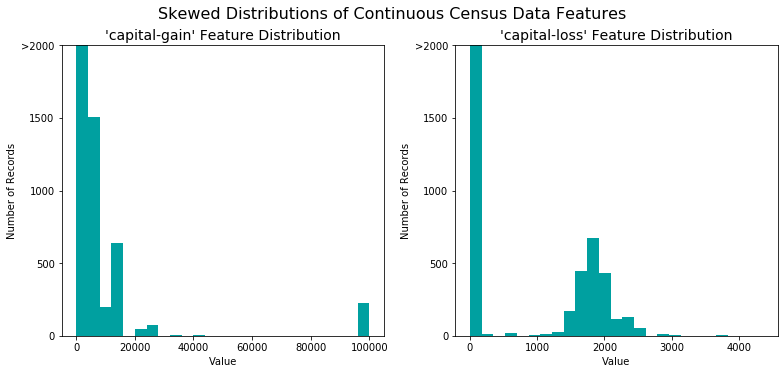

In [3]:
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(data['income']==">50K")
# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = n_at_most_50k = np.sum(data['income'] == '<=50K')


# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) /float(n_records)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

vs.distribution(data)


## Featureset Exploration 
- age: continuous. 

- workclass:Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

- education-num: continuous. 

- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

- race: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 

- sex: Female, Male. 

- capital-gain: continuous. 

- capital-loss: continuous. 

- hours-per-week: continuous. 

- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

## Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.
Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

In [4]:
# Split the data into features and target label
features =data.drop("income",axis=1)
income=data["income"]


For highly-skewed feature distributions such as 'capital-gain' and 'capital-loss', it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.
Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed.

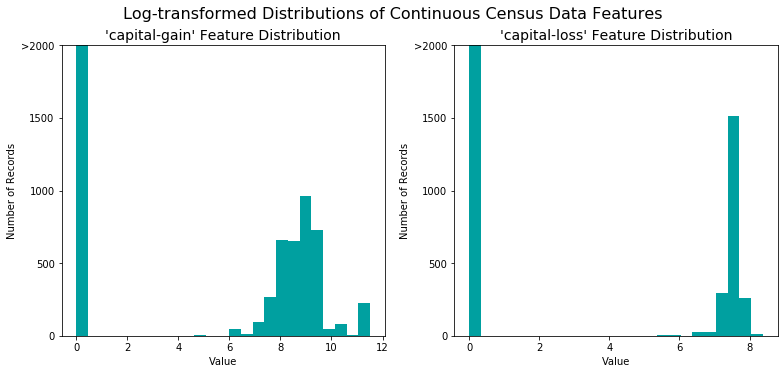

In [5]:
skewed=['capital-gain','capital-loss']
features_log_transformed=pd.DataFrame(features)
features_log_transformed[skewed]=features_log_transformed[skewed].apply(lambda x : np.log(x+1))
vs.distribution(features_log_transformed, transformed = True)


## Normalizing Numerical Features
In addition to performing transformations on features that are highly skeId, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); hoIver, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.
Run the code cell below to normalize each numerical feature. I will use sklearn.preprocessing.MinMaxScaler for this.

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
numerical=["age","education-num","capital-gain","capital-loss","hours-per-week"]
features_log_transformed[numerical]=scaler.fit_transform(data[numerical])
features_log_transformed=pd.DataFrame(data=features_log_transformed)

features_log_transformed

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219178,Private,Bachelors,0.800000,Never-married,Prof-specialty,Own-child,White,Male,0.000000,0.0,0.397959,United-States
45218,0.301370,Private,Bachelors,0.800000,Divorced,Prof-specialty,Not-in-family,White,Female,0.000000,0.0,0.357143,United-States
45219,0.287671,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.000000,0.0,0.500000,United-States
45220,0.369863,Private,Bachelors,0.800000,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,0.054551,0.0,0.397959,United-States


In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
final_features=pd.get_dummies(features_log_transformed)
# Encode the 'income_raw' data to numerical values
income = income.apply(lambda x: 1 if x == ">50K" else 0)
# Print the number of features after one-hot encoding
encoded=final_features.shape[1]
print("{} total features after one-hot encoding.".format(encoded))

103 total features after one-hot encoding.


## Shuffle and Split Data
Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, I will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.
Run the code cell below to perform this split.

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(final_features,income,test_size=0.2,random_state=0)
# Show the results of the split
print(f"Train samples are {X_train.shape[0]}")
print(f"Train samples are {X_test.shape[0]}")

Train samples are 36177
Train samples are 9045


## Evaluating Model Performance
In this section, I will investigate fmy different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of ymy choice, and the fmyth algorithm is known as a naive predictor.

## Metrics and the Naive Predictor
CharityML, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that does not make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is more important than the model's ability to recall those individuals. I can use F-beta score as a metric that considers both precision and recall:

In particular, when , more emphasis is placed on precision. This is called the <strong>F score (or F-score for simplicity).


In [9]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0
accuracy = float(TP)/(TP+FP)
recall = float(TP)/(TP+FN)
precision = accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision+recall)

# Print the results 
print( "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


## Supervised Learning Models
The following are some of the supervised learning models that are currently available in scikit-learn that you may choose from:

- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression


Random Forest

Random forest model can be applied in medical domain to identify a disease based on symptoms. 

Example: detection of Alzheimer's disease.

Strengths - very good for large datasets, gives estimates of feature's importance, can be run in parallel to speed up training, reduces variance caused by decision trees by combining multiple decision trees.

Weaknesses - relatively high prediction time

Candidacy - random forest gives good performance when there are categorical variables. As there are around 45000 entries, random forest can train much better.


Gradient Boosting

Gradient Boosting can be applied in ranking algorithms, like ranking of searches by search engines. 

Example: McRank: Learning to Rank Using Multiple Classification and Gradient Boosting.

Strengths - very good for large datasets, reduces bias and variance, combines multiple weak 

predictors to a build strong predictor.

Weaknesses - relatively high training time, over-fitting if the data sample is too small.

Candidacy - the data we have is sufficiently large and clean so gradient boosting is suitable in this case.

Bootstrap Aggregation (or Bagging for short), is a simple and very powerful ensemble method. Bagging is the application of the Bootstrap procedure to a high-variance machine learning algorithm, typically decision trees.

Example :Bootstrap refers to random sampling with replacement. Bootstrap allows us to better understand the bias and the variance with the dataset

Strengths -  Bootstrap involves random sampling of small subset of data from the dataset. This subset can be replace. The selection of all the example in the dataset has equal probability. This method can help to better understand the mean and standand deviation from the dataset.

predictors to a build strong predictor.

Weaknesses - more complex the model gets

Candidacy- This algorithm train and selects the strong classifiers on subsets of data to reduce variance error


## Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. my implementation here will be used in the following section. In the code block below, I will need to implement the following:

- Import fbeta_score and accuracy_score from sklearn.metrics.
- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data X_test, and also on the first 300 training points X_train[:300].
- Record the total prediction time.
- Calculate the accuracy score for both the training subset and testing set.
- Calculate the F-score for both the training subset and testing set.


In [24]:
from sklearn.metrics import accuracy_score , fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test[:300])
    predictions_train =learner.predict(X_train[:300])
    end = time() 
   
    
    
    # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test[:300], predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test[:300], predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

## Implementation: Initial Model Evaluation
In the code cell, I will need to implement the following:
Import the three supervised learning models I've discussed in the previous section.
Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'.Use a 'random_state' for each model I use, if provided.

Note: Use the default settings for each model — I will tune one specific model in a later section.
Calculate the number of records equal to 1%, 10%, and 100% of the training data.
Store those values in 'samples_1', 'samples_10', and 'samples_100' respectively.
Note: Depending on which algorithms I chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
BaggingClassifier trained on 361 samples.
BaggingClassifier trained on 3617 samples.
BaggingClassifier trained on 36177 samples.


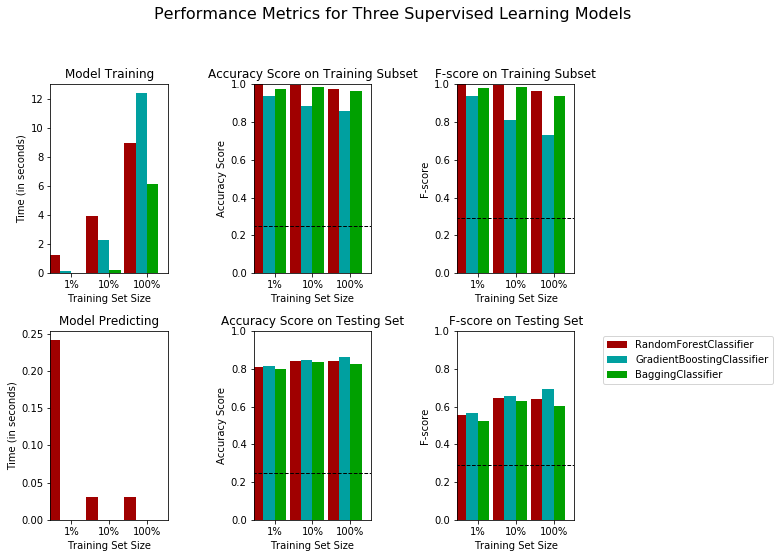

In [25]:
#  Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
# TODO: Initialize the three models
clf_A = RandomForestClassifier()
clf_B = GradientBoostingClassifier()
clf_C = BaggingClassifier()

#  Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = X_train.shape[0]
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
        
vs.evaluate(results, accuracy, fscore)



## Improving Results
In this final section, I will choose from the three supervised learning models the best model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

##  Choosing the Best Model
Based on the evaluation I performed earlier, in one to two paragraphs, explain to CharityML which of the three models I believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 
HINT: Look at the graph at the bottom left from the cell above(the visualization created by vs.evaluate(results, accuracy, fscore)) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
metrics - F score on the testing when 100% of the training data is used, 
prediction/training time
the algorithm's suitability for the data.


I choose to go with GradientBoostingClassifier() . This classifier can compensate for this after tuning as it will be able to discover more complex dependencies, this will however be done at the cost of more time for fitting.

Describing the Model in Layman's Terms

In one to two paragraphs, explain to CharityML, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.
# HINT: 

When explaining My model, if using external resources please include all citations.

## Implementation: Model Tuning

Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. I will need to use the entire training set for this. In the code cell below, I will need to implement the following:

Import sklearn.grid_search.GridSearchCV and sklearn.metrics.make_scorer.

Initialize the classifier you've chosen and store it in clf.

Set a random_state if one is available to the same state you set before.

Create a dictionary of parameters you wish to tune for the chosen model.

Example: parameters = {'parameter' : [list of values]}.

Note: Avoid tuning the max_features parameter of your learner if that parameter is available!

Use make_scorer to create an fbeta_score scoring object (with ).

Perform grid search on the classifier clf using the 'scorer', and store it in grid_obj.

Fit the grid search object to the training data (X_train, y_train), and store it in grid_fit.

Note: Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [15]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 
    "n_estimators":[10,100,1000]
    }
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit =  grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8712
Final F-score on the testing data: 0.7516


In [17]:
print(best_clf)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## Feature Relevance Observation

When Exploring the Data, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

Answer:

The five features I belive most important for prediction in the order of importance are:

capital-gain - measures how much profit an individual is making, should be greatly dependent on income.

capital-loss - total loss suffered by an individual.

education-num - would provide some insight into how educated an individual is, higher the education, higher could be the income.
marital-status Married-civ-spouse

age - more experienced/older people could be earning higher compared to younger people.

## Implementation - Extracting Feature Importance

Choose a scikit-learn supervised learning algorithm that has a feature_importance_ attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.
In the code cell below, I will need to implement the following:

Import a supervised learning model from sklearn if it is different from the three used earlier.
Train the supervised model on the entire training set.
Extract the feature importances using '.feature_importances_'.

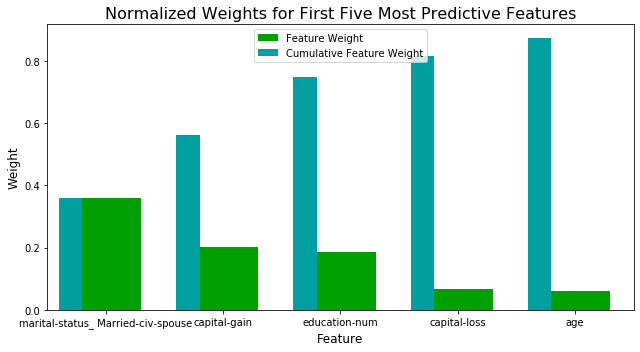

In [18]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Train the supervised model on the training set 
clf = best_clf
model = clf.fit(X_train, y_train)
# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## Extracting Feature Importance
Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.

The five features presented by the visualization are really close to what I predicted. Though occupation doesn't seem to be causing much effect on income as I thought. Also, educationcal qualification doesn't seem to be higher than age in importance which is unexpected.

## Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, I see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that I can attempt to reduce the feature space and simplify the information required for the model to learn. The code cell below will use the same optimized model I found earlier, and train it on the same training set with only the top five important features.

In [26]:
from sklearn.base import clone

# Reduce the feature space

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))) 
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8712
F-score on testing data: 0.7516

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6900


 ## Effects of Feature Selection
How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
If training time was a factor, would you consider using the reduced data as your training set?

The scores of the top 5 features performs worse than using all of the features, but it takes far less time for training and testing. This method of reducing the number of features to the most important, is a good strategy when time is limited.